In [1]:
from collections import defaultdict, Counter
from operator import itemgetter
import re,operator
import bz2, json
from collections import defaultdict
import cmath
WORD_LEN_COEFF = 1
THRESHOLD_COEFF = 0.5
DROP = 1.5
DROP_1 = 2
AFFIX_LEN = 1

trie, voc, words = None, None, None


def main():
    global trie, words, voc
    
    voc = load_voc()
    words = list(voc.keys())
    word_count = sum([voc[k] for k in voc])
    average_word_len = sum([len(w)*voc[w] for w in words]) / word_count
    len_search = int(average_word_len * WORD_LEN_COEFF) #это максимальная разрешенная длина аффикса
    print("{} словоформ, {} словоупотреблений, средняя длина слова {} ".format(len(words), word_count, average_word_len))

    # подсчет безусловных вероятностей букв
    # trie, prob = build_trie_and_prob(voc)
    prob = json.load(open("prob.json", encoding="utf-8"))
    strie = bz2.BZ2File('trie.json.bz2', 'r').read().decode(encoding='utf-8')
    trie = json.loads(strie)
    del strie
    print("Безусловные вероятности первых 10 букв:\n========================\n", 
        sorted([(letter,nv) for letter,nv in prob.items()], key=itemgetter(1), reverse=True)[:10])

    # подсчет условных вероятностей букв
    cond_prob = build_cond_prob(voc, prob, len_search)

    # информанты - это буквы с макс значением КФ в каждой позиции
    informants = find_informants(prob, cond_prob, len_search)
    print("ИНФОРМАНТЫ:\n===================")
    print(informants)

    # отправной аффикс начинаем строить с информанта имеющего max КФ
    affix=informants[0]
    affix=extend_right(*affix)
    affix=extend_left(affix, trie, len_search)
    print("ОТПРАВНОЙ АФФИКС:\n===================")    
    print(affix)



def load_voc():
    # Загрузить словарь количеств из файла.
    # Словарь содержит частоты слов в виде {слово: число вхождений в корпус, ... },
    # например {"көппөҕү" : 4, "хазар" : 3, ...}
    #
    # корпус в формате txt  занимет 174 МБ, словарь частот в json 10,4МБ,
    # после сжатия в формат .bz2 1,7 МБ
    svoc = bz2.BZ2File('voc.json.bz2', 'r').read().decode(encoding='utf-8')
    voc = json.loads(svoc)
    del svoc
    return voc


def build_trie_and_prob(voc):
    #подсчитываем частоты букв и строим дерево оконочаний
    prob = defaultdict(lambda: 0)
    trie = {'n':0}
    for w,n in voc.items(): #для каждого слова в списке
        word = w[::-1]  # переворачиваем слово, читаем слово с конца
        current_dict = trie
        trie['n'] += n
        for letter in word:  # для буквы в слове
            prob[letter]+=n
            current_dict = current_dict.setdefault(letter, {'n': 0}) #получить значение из словаря по ключу.
                                                                     #Автоматически добавляет элемент словаря, если он отсутствует.
            current_dict['n']+=n
        current_dict['#'] = n

    total = sum([n for n in prob.values()])#84263863
    for k,v in prob.items():
        prob[k] = v/total

    return trie, prob


def build_cond_prob(voc, prob, len_search):
    letters = list(prob.keys())

    cond_prob = defaultdict(lambda: 0) #словарь для условных вероятностей
    total = defaultdict(lambda: 0)

    for word,n in voc.items():#для слова в словаре
        positions = range(-min(len_search, len(word) - 2), 0) # from -7 to 0
        for i in positions:
            cond_prob[(i, word[i])] += n
            total[i] += n # dictionary with prob of char words?

    for posChar in cond_prob: #получаем из частот вероятности
        i = posChar[0]
        cond_prob[posChar] /= total[i]

    return cond_prob


def find_informants(prob, cond_prob, len_search):
    max_cond = defaultdict(lambda: 0.0)
    maxlet = ['']*8
    #для каждой позиции ищем букву с наибольшим значением условной вероятности,
    for posChar in cond_prob:#цикл по позициям букв в условной вероятности
        aff_len = posChar[0]
        if cond_prob[posChar] > max_cond[aff_len]:
            max_cond[aff_len] = cond_prob[posChar]
            maxlet[-aff_len] = posChar[1]

    print("Наиболее частые буквы по позициям:\n============================\n", maxlet[-1:0:-1],"\n")

    print("Максимальные вероятности по позициям:\n============================\n", max_cond,"\n")
    #порог медиального разбиения - половина условной вероятности , буквы с УВ не меньше порога - верхнее подмножеств
    cond_prob_sup = {}
    for posChar in cond_prob:
            i = posChar[0]
            if cond_prob[posChar] > THRESHOLD_COEFF * max_cond[i]:
                cond_prob_sup[posChar] = cond_prob[posChar]

    # КФ = условная вер по данной позиции / безусл вероятность
    cf = {}
    for posChar in cond_prob_sup:
        char = posChar[1]
        cf[posChar] = cond_prob_sup[posChar] / prob[char]

    print("КФ для верхних подмножества:\n====================\n");
    for aff_len in set(map(itemgetter(0), cf.keys())):
        print(aff_len, "**")
        for k,v in cf.items():
            if k[0] == aff_len:
                print(k[1], "{:.4f}".format(v), end="  ")
        print("")

    # информанты - это буквы с макс значением КФ в каждой позиции
    informants = []
    for aff_len in range(-len_search, 0):
        kmax = max({k for k in cf if k[0] == aff_len}, key=lambda k: cf[k])
        informants.append((kmax[1], aff_len, cf[kmax]))

    informants.sort(key = itemgetter(2), reverse=True)
    return informants


def extend_right(char, pos, cf):
    if pos == -1:#если информант в последней позиции, то расширять некуда
        return char #возвращаем информант как аффикс
    d = defaultdict(int)
    for w,n in voc.items():#для буквы и частоты в словаре
        if w[pos:pos+1]==char: #если буква в позиции равна нашей, то посчитаем это окончание
            d[w[pos+1:]]+=n
    return char+max(d.keys(), key=lambda end: d[end]) #прибавляем к информанту самое частое окончание


def extend_left(affix, trie, len_search):
    #расширяем аффикс влево используя trie

    current_dict = trie
    for ch in affix[::-1]:
        current_dict = current_dict[ch]

    aff_len = len(affix)

    """ 
    Для поиска буквы слева:
        идем по дереву trie
        по две самые частотные буквы делим друг на друга, при мере перепада большей 1.5 прибавляем к информанту более частую из них.
       Иначе начинаем рассматривать по две самые частотные буквы/на следующие две, 
    если мера перепада в одной из них больше двух, то из данной пары берем более частотную и прибавляем ее к аффиксу. 
    """
    #пока позиция символа в слове больше разрешенной длины аффикса
    while aff_len < len_search:
        #составляем список всех букв предшествующих аффиксу с количествами
        L = [(l, current_dict[l]["n"]) for l in current_dict.keys() if l not in '#n']
        #сортируем по количествам
        L.sort(key = itemgetter(1), reverse = True)
        #if affix=='нан':
            #import pdb
            #pdb.set_trace()
        ch = L[0][0]
        if L[0][1] > DROP*L[1][1]:
            affix = ch + affix
            current_dict = current_dict[ch]
        else:
            if (L[0][1]+L[1][1]) / (L[2][1]+L[3][1]) > 2:
                affix = ch + affix
                current_dict = current_dict[ch]
            else:
                break
        aff_len+=1

    return affix


def more():


    #базы первого вида
    bases = [w[0:-aff_len] for w,n in voc.items() if w[-aff_len:]==affix and n>3] #отбрасываем информантный аффикс и получаем базы 1го вида
    #bases.sort(key = itemgetter(1), reverse = True)
    bases = sorted(bases)
    #спектр остатков первого вида, т.е. находим остальные слова содержащие базы 1го вида, и отсекаем их и получаем СОПП
    ostat = defaultdict(int)
    for b in bases:
        for w,n in voc.items():
            if not w.startswith(b):
                continue
            ostat[w[len(b)+1:]]+=n

    #print(ostat)

    # теперь нужно упорядочить спектр остатков по частоте в убывающем порядке
    ostat=ostat.sort(key = itemgetter(0), reverse=True)
    #выделяем из спектра сотатков верхнее подмножество, для р.яз первые 6 аффиксов спектра
    # - для каждой позиции находится буква с наибольшим УВ, половина ее УВ - порог медиального разбиения
    #буквы, УВ которых не меньше данного порога входят в верхнее подмножество

    #определим независимую вероятность буквосочетания(остатков верхнего подмножества), как произведение независимых вероятностей букв входящих в него.
    # uncond_prob = defaultdict()
    # for k,v in ostat.items():
    #     for
    #         uncond_prob[k] *= prob[k]

    #затем находим условную вероятность остатка(?), по максимальному значению условной вероятности определяем
    #второй информантный аффикс по максимуму условной вероятности (в верхнем подмножестве)
    #сопоставляем количество основ сочетающихся с первым информантным аффиксом и
    #число основ со вторым информантным аффиксом стр38

    #Языковой шлейф. Шлейфовый порог при работе с базами n-го вида - выберем число n
    # т.е. убираем из списка баз все основы с суммарной синтагматической встречаемостью(вероятность относительно текста)
    #с любыми остатками, меньшую или равную n
    #полученный список будет содержать М баз n-го вида

    #после применения шлейфового порога и вычисления коэффициента редукции вычислим меру редукции

    # Compute reduction coefficient
    k = 10**(cmath.log(average_word_len, 10)\
                    / (1+0.02 * cmath.log( len(voc), 10)) )
        # Compute reduction threshold
    thres_reduction = 1 / average_word_len

In [2]:
main()

386233 словоформ, 11859267 словоупотреблений, средняя длина слова 7.1053179762290535 
Безусловные вероятности первых 10 букв:
 [('а', 0.13174638100795355), ('т', 0.07463523242460413), ('н', 0.07183703410321932), ('р', 0.06989005476760542), ('э', 0.06769593508904286), ('и', 0.06497202721408583), ('ы', 0.05657750345483212), ('л', 0.052736912856701096), ('у', 0.048080219156342266), ('о', 0.04801633649290444)]
Наиболее частые буквы по позициям:
 ['а', 'а', 'т', 'а', 'т', 'а', 'н'] 

Максимальные вероятности по позициям:
 defaultdict(<function find_informants.<locals>.<lambda> at 0x000001F90DD702F0>, {-6: 0.13725284548556266, -5: 0.10984460793132571, -4: 0.13300193926114215, -3: 0.11746170593037474, -2: 0.21185955687204952, -1: 0.22671356984582827, -7: 0.10984867258690777}) 

КФ для верхних подмножества:

-1 **
н 3.1559  р 2.0092  а 1.1595  
-7 **
ы 0.9773  р 1.1054  а 0.8338  л 1.7512  т 1.0604  и 0.9824  
-6 **
р 0.9975  а 1.0418  т 0.9701  э 1.0297  л 1.6040  
-5 **
а 0.7812  н 0.8144  т

### отправной аффикс

In [3]:
affix='ыытынан'

In [4]:
extend_left('н',trie, 7)

'ыытынан'

### основы с первым информантным аффиксом

In [5]:
bases = [w[0:-7] for w,n in voc.items() if w[-7:]==affix and n>3]
bases

['хаһ',
 'бар',
 'тардыһ',
 'ыпс',
 'кыт',
 'тард',
 'сам',
 'ыҥыр',
 'ань',
 'улаат',
 'сайд',
 'сыр',
 'ый',
 'ахт',
 'баай',
 'такай',
 'хапсыһ',
 'ыл',
 'арый',
 'аһылл',
 'хамсан',
 'кытт',
 'хаам',
 'т',
 'тал',
 'хааччылл',
 'ай',
 'таһын',
 'ааҕ',
 'дьаһай',
 'быһаар',
 'ар',
 'хаай',
 'салай',
 'таһаар',
 'дьай',
 'баттаһ',
 'ыг',
 'ат',
 'кыр',
 'хард',
 'тымн',
 'сым',
 'ыар',
 'уларый',
 'быс',
 'аҕаб',
 'таһ',
 'туһаай',
 'ыһ',
 'быһ',
 'кымнь',
 'кыай',
 '',
 'ааҕылл',
 'саҕалан',
 'быраҕ',
 'тахс',
 'сылый']

### ищем верхнее подмножество из остатков

In [6]:
prob = defaultdict(lambda: 0)
trie = {'n':0}
for w,n in voc.items(): #для каждого слова в списке
        word = w[::-1]  # переворачиваем слово, читаем слово с конца
        current_dict = trie
        trie['n'] += n
        for letter in word:  # для буквы в слове
            prob[letter]+=n
            current_dict = current_dict.setdefault(letter, {'n': 0}) #получить значение из словаря по ключу.
                                                                     #Автоматически добавляет элемент словаря, если он отсутствует.
            current_dict['n']+=n
        current_dict['#'] = n

total = sum([n for n in prob.values()])#84263863
for k,v in prob.items():
        prob[k] = v/total


In [18]:
ostat = defaultdict(int)
for b in bases:
    for w,n in voc.items():
            if not w.startswith(b):
                continue
            ostat[w[len(b):]]+=n#было длина + 1

### окончания от баз встречающихся с первым информантным аффиксом

In [27]:
ostat #окончания от баз

defaultdict(int,
            {'ааныыга': 3,
             'ыллыбыт': 4994,
             'аайыстыбалааҕын': 1,
             'ааныма': 1,
             'ыытастыбыт': 2,
             'аайыным': 7,
             'ыытынан': 17369,
             'аайкатабын': 2,
             'аахха': 270,
             'аахтара': 109,
             'ыаттанар': 1,
             'ыҥ': 819,
             'ааммыттарын': 2,
             'ыытаатахха': 1,
             'ааҥ': 13,
             'ааҥҥадиэри': 1,
             'аанарбыт': 1,
             'аайыннаммыккыт': 1,
             'ыспаппын': 7,
             'аайыммытын': 2,
             'ыйаан': 275,
             'ыаттарга': 424,
             'аҕын': 1999,
             'аайыный': 1,
             'ыыталастылар': 1,
             'ыытаатахпына': 1,
             'аайыстыбалааххын': 1,
             'аайыстыбалартан': 46,
             'аайыннаахтарын': 1,
             'ааттарын': 864,
             'аага': 22,
             'аайынныыллара': 1,
             'аайыстыбаннайа': 11,


In [12]:
#отсортированные окончания от баз м первым информантным аффиксом
sorted([(letter,nv) for letter,nv in ostat.items()], key=itemgetter(1), reverse=True)

[('да', 128298),
 ('уонна', 108844),
 ('диэн', 107255),
 ('ан', 102865),
 ('ол', 96589),
 ('бу', 89225),
 ('а', 69984),
 ('саха', 63385),
 ('курдук', 60842),
 ('киһи', 57351),
 ('эрэ', 56714),
 ('суох', 53663),
 ('биир', 51116),
 ('ар', 46203),
 ('дьон', 39867),
 ('баран', 37609),
 ('биһиги', 33994),
 ('эмиэ', 33676),
 ('улахан', 33468),
 ('баар', 32860),
 ('онон', 32576),
 ('уһунан', 32521),
 ('туһунан', 32521),
 ('ити', 31302),
 ('оҕо', 31245),
 ('та', 31220),
 ('буолан', 30095),
 ('оттон', 30076),
 ('кини', 29991),
 ('кытта', 29921),
 ('ын', 29324),
 ('ыы', 28203),
 ('эбит', 28150),
 ('этэ', 27433),
 ('билигин', 26992),
 ('мин', 26700),
 ('сөп', 26242),
 ('икки', 26203),
 ('уох', 25704),
 ('туох', 25700),
 ('урар', 25454),
 ('турар', 25454),
 ('сыл', 25453),
 ('ону', 24847),
 ('саҥа', 23306),
 ('иһин', 22030),
 ('элбэх', 21659),
 ('ы', 20282),
 ('ыа', 20098),
 ('буолар', 19636),
 ('олус', 19104),
 ('хайдах', 18974),
 ('диэри', 18965),
 ('аас', 18722),
 ('сирэ', 18610),
 ('сирин', 18

In [13]:
ostat = defaultdict(int)
for b in bases:
    for w,n in voc.items():
            if not w.startswith(b):
                continue
            ostat[w[len(b):]]+=n#было длина + 1

In [20]:
bases_with_ostat=defaultdict(int)
for w,n in voc.items():
            if not w.endswith('нан'):
                continue
            bases_with_ostat[w]+=n

In [21]:
bases_with_ostat

defaultdict(int,
            {'хоруунан': 2,
             'куубатынан': 1,
             'чоргуйбутунан': 2,
             'балаһыанньабытынан': 6,
             'остеопороһунан': 1,
             'коррепонденынан': 1,
             'сааһырбыттарынан': 1,
             'сулууспанан': 27,
             'суоттаммытынан': 2,
             'консалтинынан': 1,
             'куһаҕаннарынан': 1,
             'тохтотулларынан': 2,
             'соҕотохсуйуутунан': 1,
             'былыргыларынан': 1,
             'ылынаргытынан': 1,
             'сатабылларынан': 9,
             'ускуустубанан': 5,
             'кыстыырынан': 1,
             'дьыалаланан': 4,
             'судаарыстыбаннайынан': 2,
             'толорбуппутунан': 1,
             'аймахтарынан': 52,
             'оттубутунан': 2,
             'кычыгыланан': 21,
             'суоттуурунан': 11,
             'кураҥынан': 1,
             'нууччалыытынан': 3,
             'тыксаанынан': 1,
             'ыҥырыгынан': 6,
             'туоста

In [41]:
sum=defaultdict(int)#число основ с этим остатком
bases_with_ostat = defaultdict(int)
for o in ostat:
    for w,n in trie[o]:
            if not w.endswith('нан'):
                continue
            bases_with_ostat[w]+=n
            sum['нан']+=n
sum

KeyError: 'ааныыга'

In [85]:
bases_with_ostat

defaultdict(int,
            {'аахсыытынан': 4,
             'ааҕыллыытынан': 8,
             'ааҕыытынан': 82,
             'айыытынан': 8,
             'алдьаныытынан': 2,
             'алпабыытынан': 2,
             'анаарыытынан': 2,
             'аньыытынан': 8,
             'араарыытынан': 2,
             'араастаһыытынан': 6,
             'арыйыытынан': 68,
             'арыллыытынан': 4,
             'арыытынан': 24,
             'атастаһыытынан': 4,
             'аттарыытынан': 2,
             'атыылаһыытынан': 4,
             'атыытынан': 38,
             'ахсыытынан': 2,
             'ахтыытынан': 14,
             'аҕабыытынан': 26,
             'аҕалыытынан': 2,
             'аҥаардыытынан': 2,
             'аһыллыытынан': 38,
             'аһыытынан': 6,
             'баайыытынан': 10,
             'бандьыытынан': 2,
             'барыытынан': 10,
             'баттаһыытынан': 14,
             'баҕарыытынан': 2,
             'баһыйыытынан': 2,
             'баһыытынан': 2,

In [19]:
sum=defaultdict(int)#число основ с этим остатком
bases_with_ostat = defaultdict(int)
#for o in ostat:
for w,n in voc.items():
            if not w.endswith('нан'):
                continue
            bases_with_ostat[w]+=n
            sum['нан']+=n
sum

defaultdict(int, {'нан': 226046})

#### число основ с данными окончаниями

In [43]:
def osnova(a):
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    return current_node

In [37]:
osnova('ааныыга')#число основ с окончанием ааныыга

{'n': 4,
 'с': {'#': 1, 'n': 1},
 'һ': {'n': 3, 'а': {'n': 3, 'х': {'#': 3, 'n': 3}}}}

In [46]:
osnov_s_ost=defaultdict(int)
for o in ostat:
    osnov_s_ost[o]=osnova('n'+o)
osnov_s_ost

defaultdict(int,
            {'ааныыга': 4,
             'ыллыбыт': 10760,
             'аайыстыбалааҕын': 1,
             'ааныма': 3,
             'ыытастыбыт': 2,
             'аайыным': 7,
             'ыытынан': 17491,
             'аайкатабын': 2,
             'аахха': 11441,
             'аахтара': 3529,
             'ыаттанар': 5,
             'ыҥ': 15046,
             'ааммыттарын': 5,
             'ыытаатахха': 1,
             'ааҥ': 1100,
             'ааҥҥадиэри': 1,
             'аанарбыт': 1,
             'аайыннаммыккыт': 1,
             'ыспаппын': 36,
             'аайыммытын': 3,
             'ыйаан': 1060,
             'ыаттарга': 425,
             'аҕын': 21882,
             'аайыный': 1,
             'ыыталастылар': 1,
             'ыытаатахпына': 1,
             'аайыстыбалааххын': 1,
             'аайыстыбалартан': 46,
             'аайыннаахтарын': 1,
             'ааттарын': 1551,
             'аага': 67,
             'аайынныыллара': 1,
             'аайыстыба

### общее число словоформ с этими основами


In [ ]:
#bases - основы с первым информантным аффиксом

In [51]:
def osnova1(a):
    current_node = trie
    for char in a:
        current_node = current_node[char]
    return current_node

In [52]:
osnova1('барб')

{'n': 0,
 'а': {'n': 0,
  'к': {'n': 0,
   'к': {'n': 0,
    'а': {'n': 0, 'л': {'n': 0, 'а': {'n': 0, 'р': {'#': 0, 'n': 0}}}}}},
  'т': {'n': 0,
   'а': {'n': 0,
    'л': {'n': 0, 'л': {'n': 0, 'а': {'n': 0, 'р': {'#': 0, 'n': 0}}}}},
   'ы': {'n': 0, 'л': {'n': 0, 'а': {'n': 0, 'р': {'#': 0, 'n': 0}}}}},
  'х': {'n': 0,
   'т': {'n': 0,
    'а': {'n': 0,
     'һ': {'n': 0,
      'а': {'n': 0,
       'л': {'n': 0,
        'л': {'n': 0, 'а': {'n': 0, 'р': {'#': 0, 'n': 0}}}}}}}}}},
 'и': {'n': 0, 'л': {'n': 0, 'а': {'n': 0, 'р': {'#': 0, 'n': 0}}}}}

In [ ]:
osnov_s_ost=defaultdict(int)
for o in ostat:
    osnov_s_ost[o]=osnova('n'+o)
osnov_s_ost

In [ ]:
for w,n in voc.items(): #для каждого слова в списке
        word = w[::-1]  # переворачиваем слово, читаем слово с конца
        current_dict = trie
        trie['n'] += n
        for letter in word:  # для буквы в слове
            prob[letter]+=n
            current_dict = current_dict.setdefault(letter, {'n': 0}) #получить значение из словаря по ключу.
                                                                     #Автоматически добавляет элемент словаря, если он отсутствует.
            current_dict['n']+=n
        current_dict['#'] = n

In [18]:
sum=0
for d in bases_with_ostat.values():
    sum+=d
sum

226046

In [165]:
b=defaultdict(int)
for w,n in voc.items():
            if not w.startswith('бар'):
                continue
            b[w]+=n
b

defaultdict(int,
            {'барааттарын': 15,
             'барьердар': 1,
             'барсыбатаххына': 1,
             'барсыахтааҕын': 1,
             'баргыытыыр': 3,
             'бартыбыалын': 7,
             'баржалаахтара': 1,
             'барыахтааххын': 14,
             'барыытын': 124,
             'барыһынааҕар': 3,
             'барыһыраҕын': 3,
             'баришполтан': 1,
             'бараахтаахпыт': 1,
             'бардьыгыныыра': 1,
             'барыай': 365,
             'барбаттык': 1,
             'барарбытын': 20,
             'барыһыраллар': 6,
             'бараатыбыт': 9,
             'барыытынан': 5,
             'барыанньалаахтар': 1,
             'барыыһаптыын': 4,
             'барыйааннары': 4,
             'бараайаҕын': 1,
             'барахсин': 1,
             'барыгылдьытыы': 2,
             'барыылар': 4,
             'барчалыыллар': 1,
             'барсыбакка': 1,
             'барыанньатыгар': 1,
             'барбаппытый': 1,
           

In [166]:
sum2=0
for d in b.values():
    sum2+=d
sum2

147308

In [160]:
sum1=defaultdict(int)
word_w_bases=defaultdict(int)#число слов с этими основами
for w,n in voc.items():
    if not w.startswith('бар'):
        continue
    word_w_bases[w]+=n
    sum1['бар']+=n
sum1    

defaultdict(int, {'бар': 147308})

In [36]:
sum1=defaultdict(int)
word_w_bases=defaultdict(int)#число слов с этими основами
for w,n in trie.items():
           print(w)

n
н
р
ы
ү
а
е
т
к
э
х
ю
и
в
у
м
й
ҥ
п
г
с
ь
б
о
я
ф
д
з
ҕ
ч
л
ө
ш
ц
ж
һ
ъ
щ
ё


In [9]:
def n(a):
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    return current_node['n']

def n2(a):#функция принимает строку
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    return sorted([(k,subtree['n']) for k, subtree in current_node.items() if k not in '#n'], key=itemgetter(1), reverse=True)

In [6]:
n2('ртан')

[('а', 9999),
 ('ы', 388),
 ('о', 378),
 ('у', 250),
 ('е', 111),
 ('т', 60),
 ('и', 23),
 ('д', 14),
 ('я', 2),
 ('в', 2),
 ('п', 1),
 ('ё', 1),
 ('ю', 1),
 ('г', 1),
 ('н', 1)]

In [79]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def diag(a):
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    pairs = sorted([(k,subtree['n']) for k, subtree in current_node.items() if k not in '#n'], 
                   key=itemgetter(1), 
                   reverse=True)
    kol = [p[1] for p in pairs]
    chs = [p[0] for p in pairs]
    plt.figure(figsize=(14,7))
    plt.bar(np.arange(len(kol)), kol, tick_label=chs)
    #plt.savefig(a+'.pdf')
    plt.show()

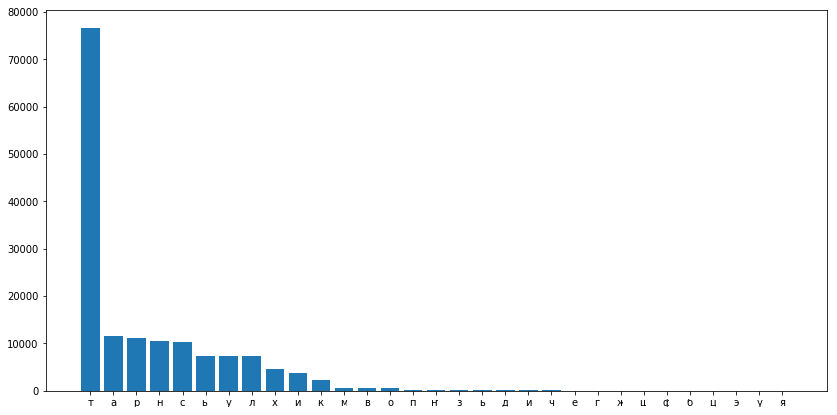

In [8]:
diag('тан')

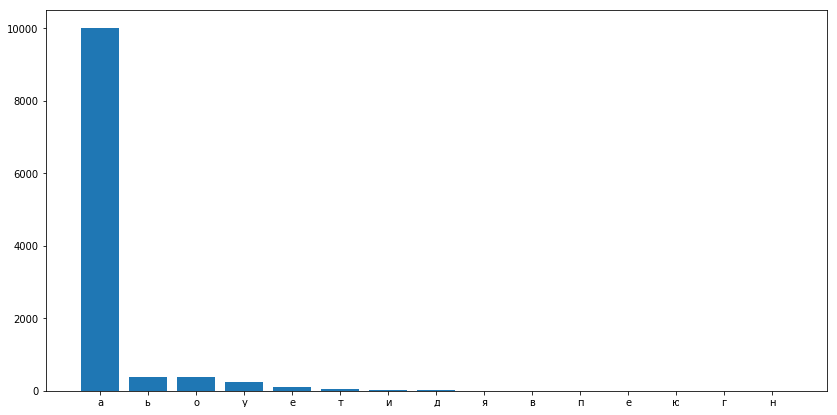

In [71]:
diag('ртан')

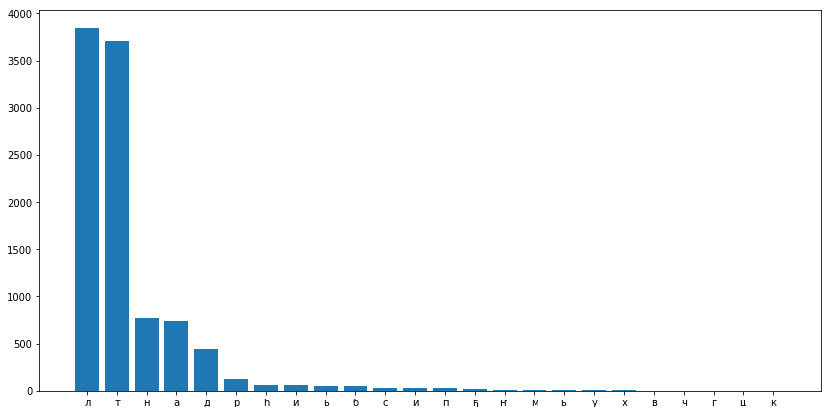

In [72]:
diag('артан')

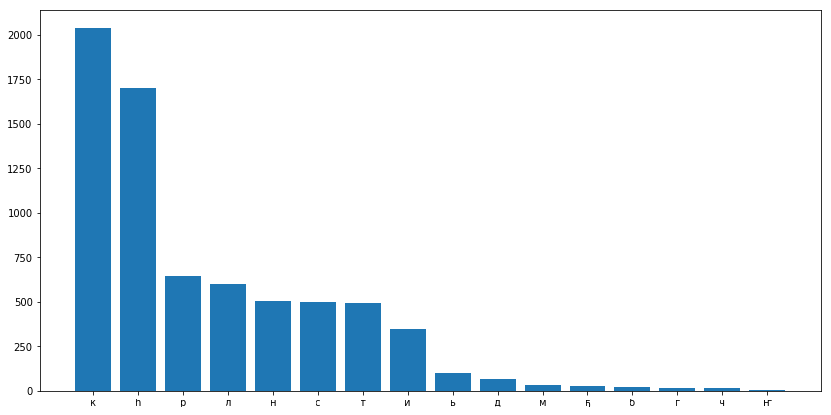

In [83]:
diag('ыах')

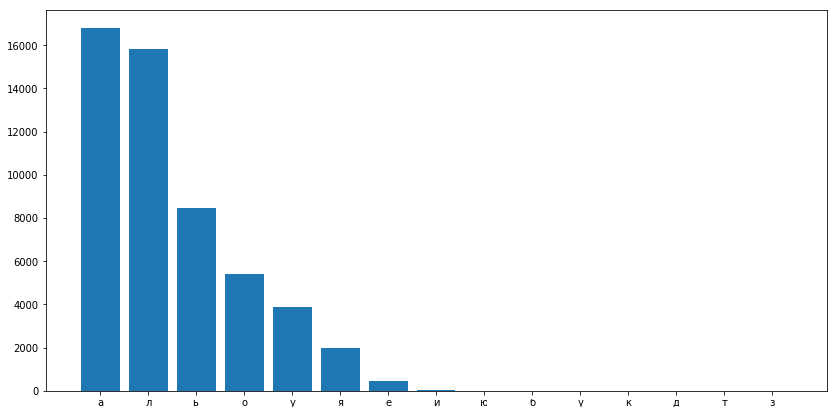

In [84]:
diag('ларын')

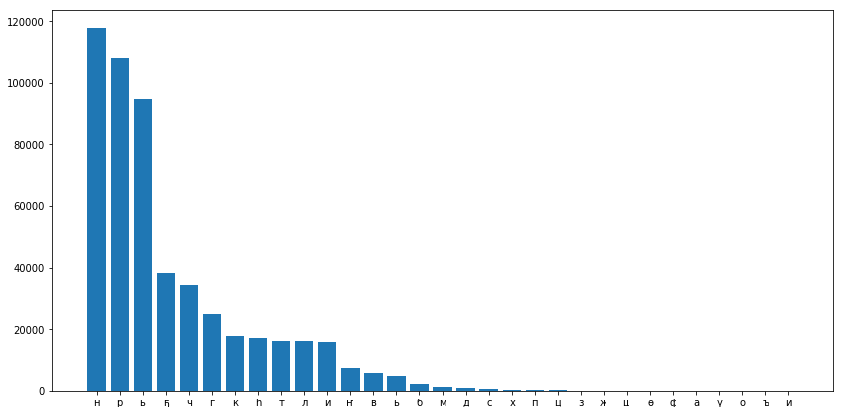

In [74]:
diag('ы')

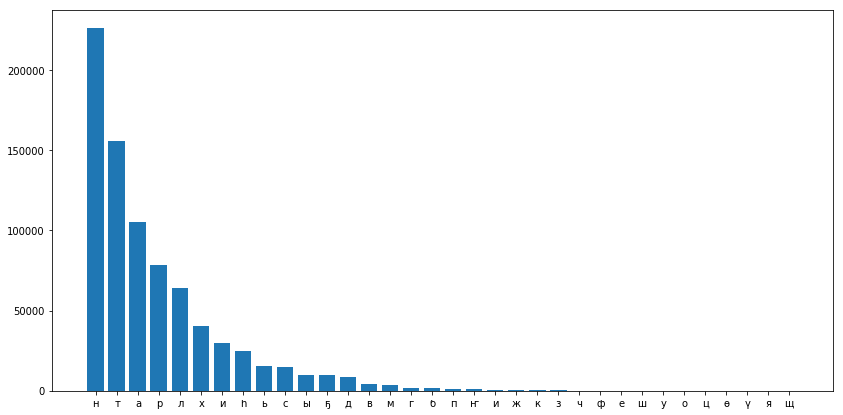

In [90]:
diag('ан')

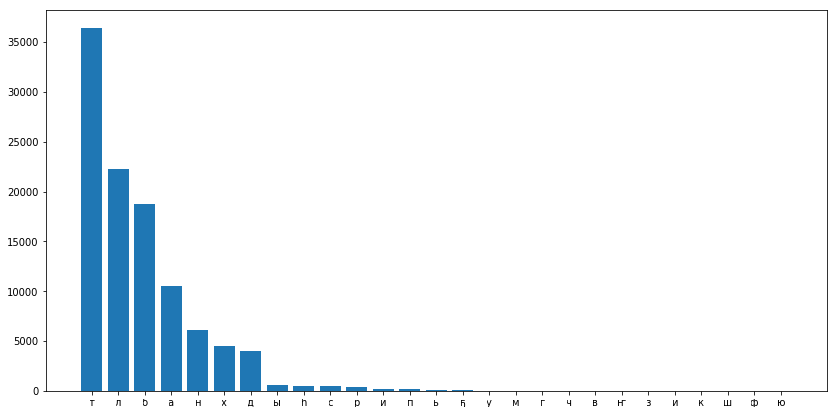

In [77]:
diag('ары')

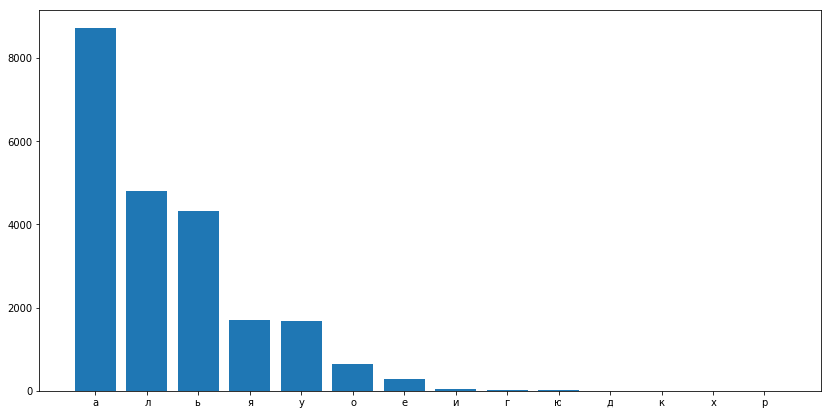

In [78]:
diag('лары')

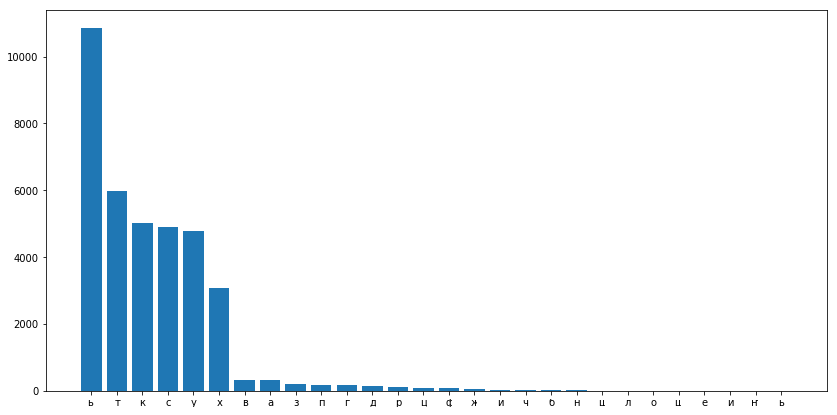

In [79]:
diag('тары')

In [10]:
print(n2('ан'))
print((155812+226046)/(105460+78300))

[('н', 226046), ('т', 155812), ('а', 105460), ('р', 78300), ('л', 63944), ('х', 40317), ('й', 29959), ('һ', 24992), ('ь', 15640), ('с', 14718), ('ы', 9975), ('ҕ', 9912), ('д', 8410), ('в', 4265), ('м', 3512), ('г', 1700), ('б', 1647), ('п', 1378), ('ҥ', 1091), ('и', 271), ('ж', 249), ('к', 232), ('з', 221), ('ч', 58), ('ф', 38), ('е', 28), ('ш', 23), ('у', 19), ('о', 9), ('ц', 8), ('ө', 2), ('ү', 1), ('я', 1), ('щ', 1)]
2.07802568567697


In [11]:
3703/776

4.771907216494846

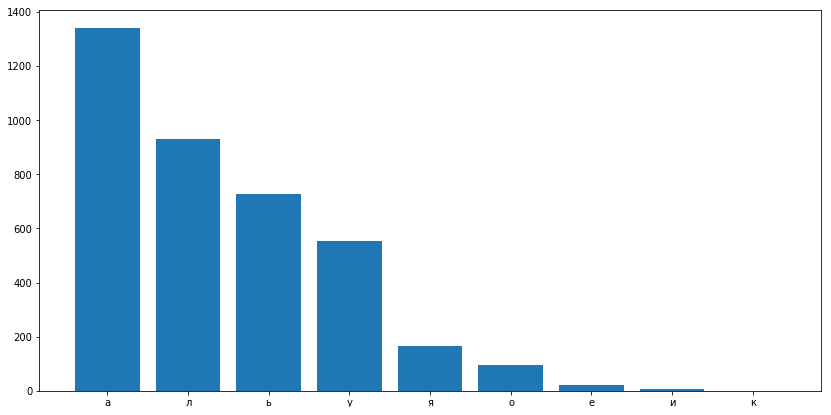

In [12]:
diag('лартан')

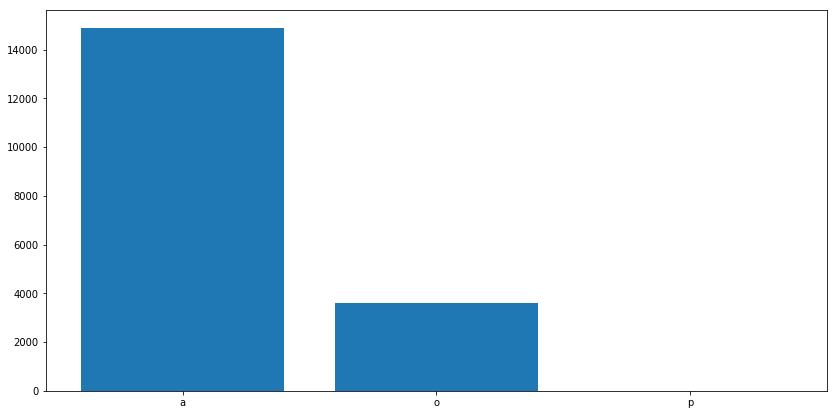

In [13]:
diag('хтара')

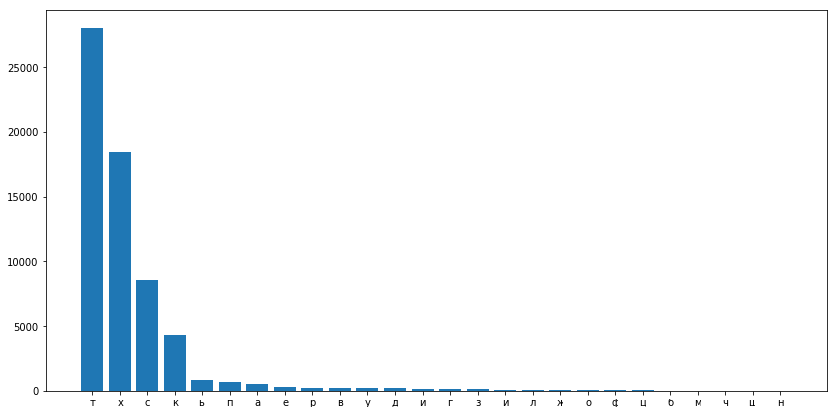

In [14]:
diag('тара')

### при информанте "н" начнем расширять аффикс

In [10]:
print(n2('н'))

[('а', 798469), ('э', 500106), ('ы', 462367), ('и', 376365), ('о', 192704), ('у', 127619), ('ү', 92134), ('ө', 42450), ('е', 5962), ('я', 925), ('й', 386), ('н', 121), ('р', 117), ('л', 109), ('ю', 40), ('т', 40), ('ё', 38), ('ш', 25), ('м', 22), ('ь', 17), ('б', 13), ('г', 6), ('к', 4), ('ц', 3), ('х', 3), ('п', 2), ('с', 2), ('в', 2), ('ж', 1), ('ҥ', 1), ('ҕ', 1), ('д', 1), ('һ', 1)]


In [11]:
798469/500106 #(>DROP)

1.5965995209015689

In [12]:
(798469+500106)/(462367+376365)

1.5482597540096241

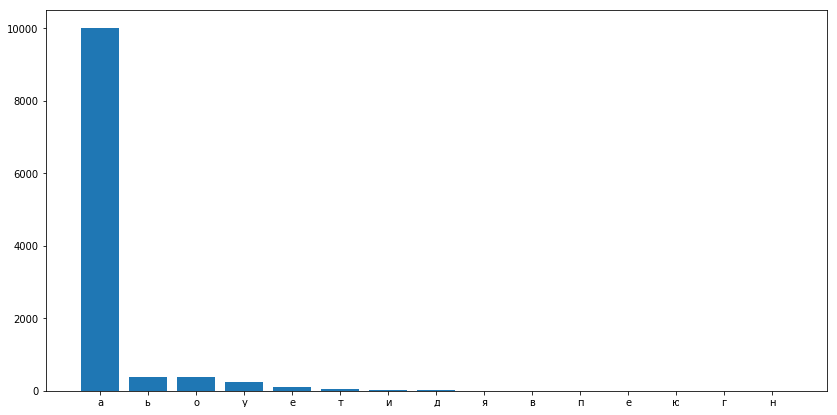

In [87]:
diag('ртан')

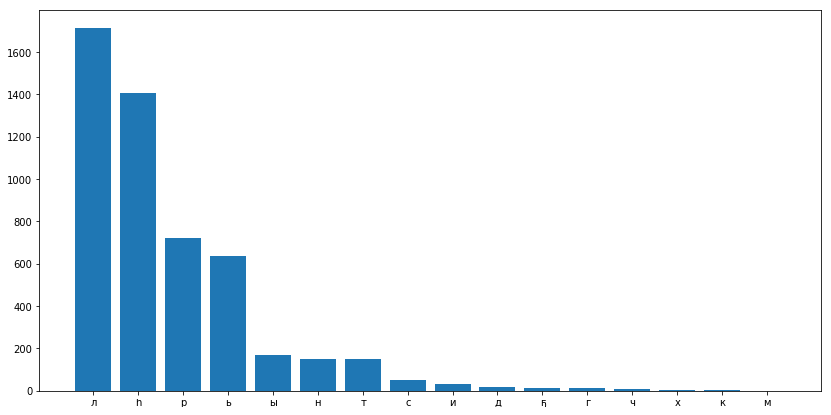

In [89]:
diag('ыма')

In [13]:
print(n2('р'))#также есть суффикс -ан

[('а', 784102), ('э', 489099), ('и', 111886), ('о', 87158), ('ы', 40056), ('ө', 36238), ('у', 29417), ('ү', 17432), ('е', 7434), ('т', 6426), ('д', 6354), ('с', 762), ('р', 365), ('ё', 183), ('я', 155), ('г', 148), ('п', 62), ('в', 62), ('н', 59), ('ю', 26), ('к', 21), ('б', 12), ('ф', 12), ('х', 7), ('й', 6), ('м', 4), ('л', 3), ('ҕ', 2)]


In [27]:
784102/489099 #а/э

1.6031560072705118

In [28]:
(784102+489099)/(111886+87158)

6.39658065553345

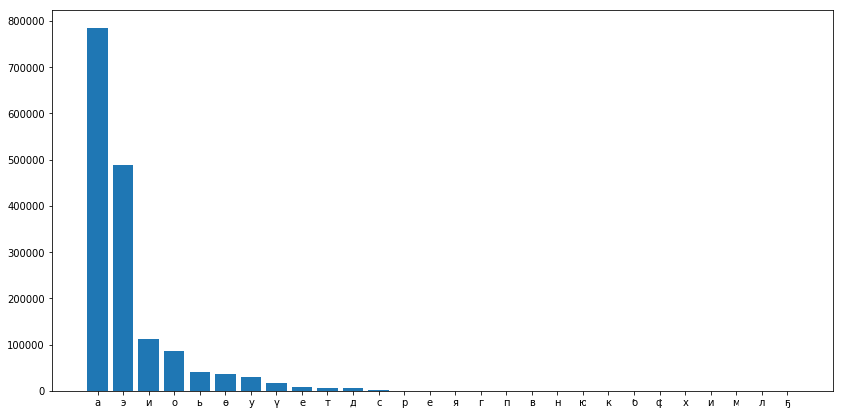

In [26]:
diag('р')

In [16]:
784102/489099 #(>DROP)

1.6031560072705118

In [17]:
print(n2('а'))

[('т', 280169), ('н', 267665), ('р', 204055), ('г', 182476), ('д', 164393), ('ҕ', 144879), ('к', 125853), ('х', 114918), ('л', 73986), ('ҥ', 51246), ('й', 42520), ('һ', 40948), ('в', 30969), ('ы', 29997), ('а', 22474), ('м', 20825), ('б', 19173), ('с', 17124), ('ч', 14591), ('п', 9540), ('ь', 8718), ('ш', 1937), ('з', 1593), ('ц', 743), ('и', 553), ('ф', 404), ('ж', 238), ('ө', 89), ('у', 60), ('ү', 26), ('щ', 13), ('я', 12), ('е', 8), ('о', 5), ('э', 0)]


In [18]:
280169/267665

1.0467151103057928

In [19]:
267665/204055

1.3117296807233343

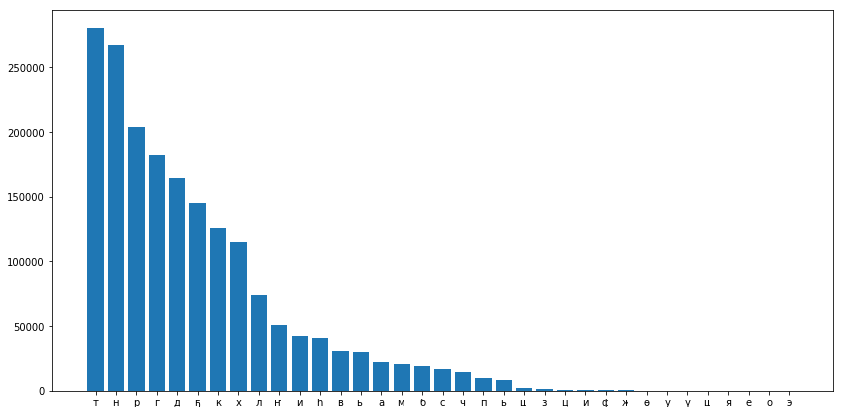

In [29]:
diag('а')

In [33]:
print(n2('а'))

[('т', 280169), ('н', 267665), ('р', 204055), ('г', 182476), ('д', 164393), ('ҕ', 144879), ('к', 125853), ('х', 114918), ('л', 73986), ('ҥ', 51246), ('й', 42520), ('һ', 40948), ('в', 30969), ('ы', 29997), ('а', 22474), ('м', 20825), ('б', 19173), ('с', 17124), ('ч', 14591), ('п', 9540), ('ь', 8718), ('ш', 1937), ('з', 1593), ('ц', 743), ('и', 553), ('ф', 404), ('ж', 238), ('ө', 89), ('у', 60), ('ү', 26), ('щ', 13), ('я', 12), ('е', 8), ('о', 5), ('э', 0)]


In [34]:
(280169/267665) #t/n

1.0467151103057928

In [35]:
(280169+267665)/(204055+182476)

1.4173093490560913

In [38]:
extend_right('л', -5, 0)

'ларын'

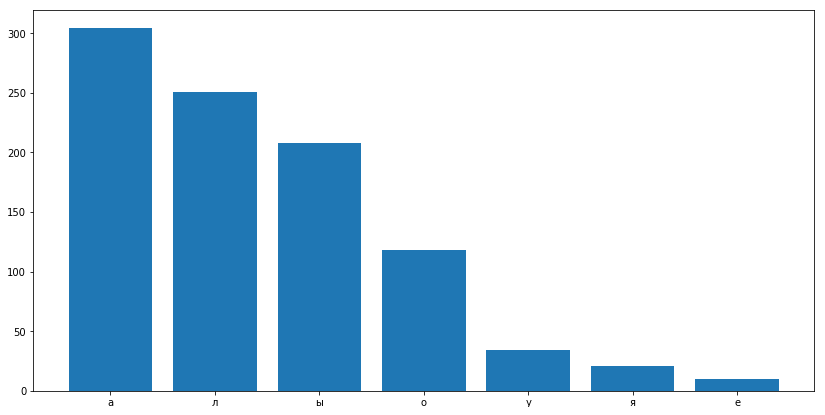

In [85]:
diag('ларбытын')

In [53]:
print(n2('ларын'))

[('а', 16772), ('л', 15837), ('ы', 8441), ('о', 5424), ('у', 3880), ('я', 1995), ('е', 443), ('и', 30), ('ю', 4), ('б', 1), ('ү', 1), ('к', 1), ('д', 1), ('т', 1), ('з', 1)]


In [42]:
16772/15837

1.059038959398876

In [43]:
(16772+15837)/(8441+5424)

2.3518932564010098

In [54]:
extend_right('э', -2, 0)

'эн'

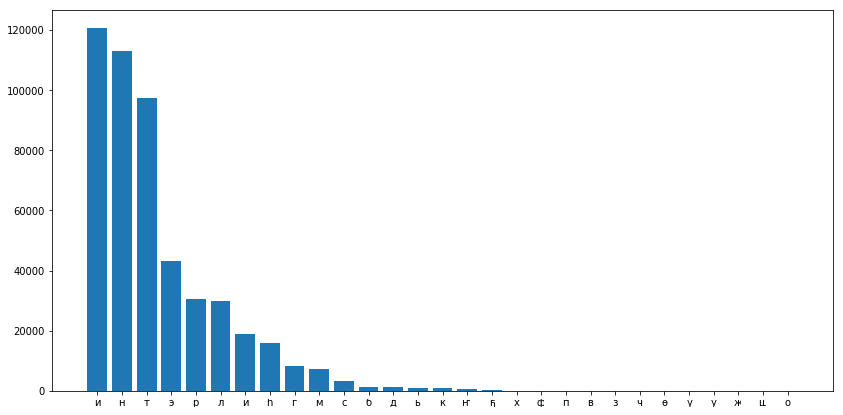

In [65]:
diag('эн')

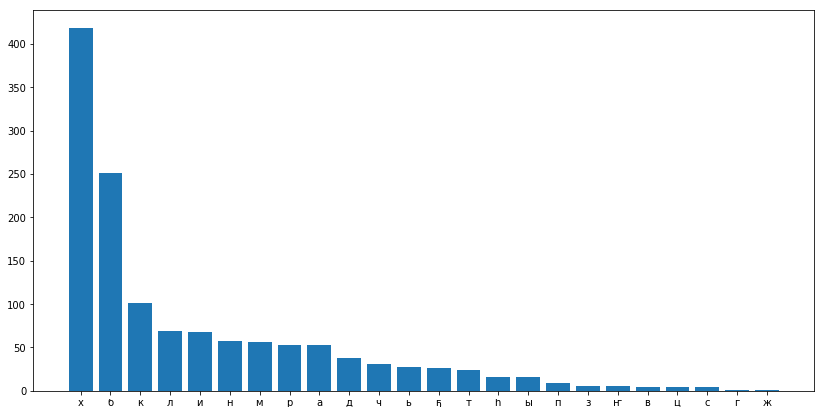

In [80]:
diag('алартан')

In [67]:
print(n2('эн'))

[('и', 120546), ('н', 113148), ('т', 97261), ('э', 43204), ('р', 30498), ('л', 29795), ('й', 19042), ('һ', 16039), ('г', 8388), ('м', 7263), ('с', 3288), ('б', 1389), ('д', 1329), ('ь', 1036), ('к', 984), ('ҥ', 662), ('ҕ', 139), ('х', 47), ('ф', 15), ('п', 5), ('в', 3), ('з', 2), ('ч', 2), ('ө', 1), ('ү', 1), ('у', 1), ('ж', 1), ('ш', 1), ('о', 1)]


In [69]:
(120546+113148)/(97261+43204)

1.6637169401630298

In [22]:
print(n2('нан')) #-нан - аффикс орудного падежа

[('ы', 128013), ('у', 63359), ('а', 30825), ('я', 1482), ('м', 853), ('о', 841), ('ҥ', 254), ('е', 238), ('и', 114), ('н', 54), ('ю', 4), ('э', 4), ('ү', 1), ('р', 1)]


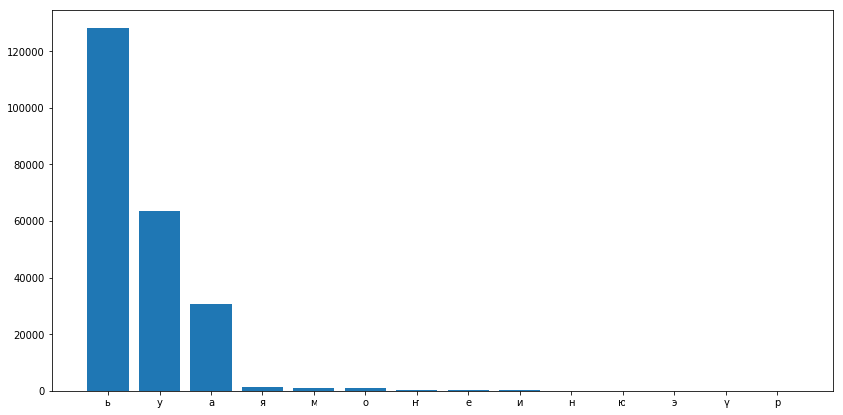

In [67]:
diag('нан')

In [28]:
print(n2('ынан')) #аффикс орудного падежа притяжат склонение

[('т', 37319), ('р', 25048), ('һ', 15515), ('г', 13760), ('л', 9141), ('ҕ', 6722), ('н', 5322), ('й', 4933), ('ы', 2237), ('к', 2026), ('ч', 1964), ('б', 1214), ('м', 761), ('д', 675), ('п', 601), ('ь', 223), ('ҥ', 194), ('в', 117), ('с', 103), ('х', 98), ('ш', 3), ('ө', 2), ('я', 1)]


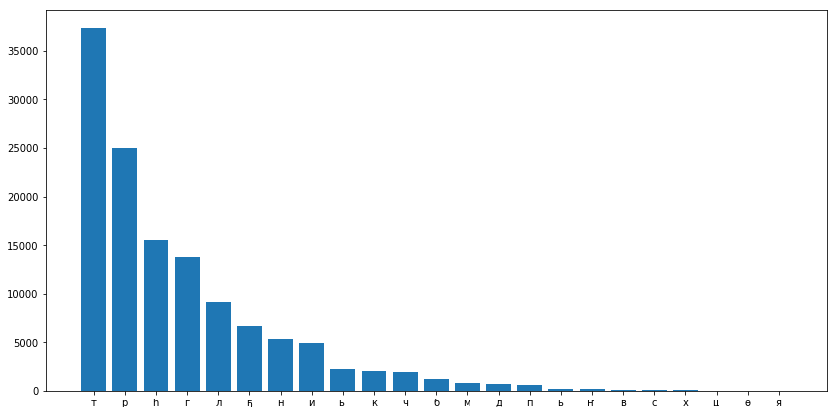

In [68]:
diag('ынан')

In [24]:
(37319+25048)/(15515+13760)

2.130384286934244

In [25]:
print(n2('тынан'))#аффикса -тынан нет

[('ы', 23981), ('а', 12000), ('с', 370), ('я', 309), ('т', 173), ('е', 161), ('о', 106), ('к', 58), ('и', 56), ('р', 46), ('п', 21), ('э', 19), ('н', 9), ('й', 7), ('ь', 2), ('л', 1)]


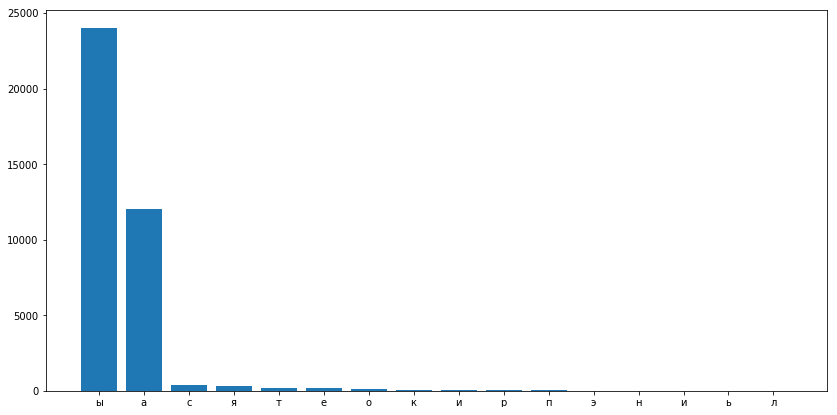

In [69]:
diag('тынан')

In [26]:
23981/12000

1.9984166666666667

In [63]:
n('ынан')/n('тынан')

3.430236608697982

In [64]:
n('нан')/n('ынан')

1.7658050354260895

In [29]:
print(n2('ытынан'))

[('ы', 17491), ('б', 2501), ('п', 960), ('ч', 787), ('к', 504), ('м', 398), ('с', 292), ('г', 231), ('ь', 207), ('т', 182), ('һ', 117), ('р', 117), ('л', 44), ('ҕ', 37), ('х', 22), ('ҥ', 15), ('й', 9)]


In [32]:
print(n('ытынан'))

23981


In [38]:
print(n('ыытынан'))

17491


In [39]:
print(n2('ыытынан'))

[('һ', 15345), ('р', 805), ('й', 636), ('т', 205), ('м', 135), ('н', 90), ('д', 79), ('л', 57), ('ҕ', 47), ('с', 30), ('ь', 25), ('б', 15), ('г', 11), ('ы', 1), ('ҥ', 1)]


In [40]:
print(n('һыытынан'))

15345


In [41]:
print(n2('һыытынан'))

[('ы', 15310), ('а', 35)]


In [42]:
print(n('ыһыытынан'))

15310


In [43]:
print(n2('ыһыытынан'))

[('б', 15251), ('д', 34), ('с', 4), ('т', 3), ('н', 2)]


In [44]:
print(n2('быһыытынан'))

[('а', 1), ('ы', 1), ('б', 1)]


In [33]:
print(n('бытынан'))

2501


In [34]:
print(n2('бытынан'))

[('а', 790), ('р', 630), ('ы', 540), ('л', 316), ('й', 210), ('я', 8), ('о', 3), ('е', 2), ('ь', 1), ('и', 1)]


In [36]:
(790+630)/(540+316)

1.658878504672897

In [37]:
540/316

1.7088607594936709

In [45]:
print(n2('р'))

[('а', 784102), ('э', 489099), ('и', 111886), ('о', 87158), ('ы', 40056), ('ө', 36238), ('у', 29417), ('ү', 17432), ('е', 7434), ('т', 6426), ('д', 6354), ('с', 762), ('р', 365), ('ё', 183), ('я', 155), ('г', 148), ('п', 62), ('в', 62), ('н', 59), ('ю', 26), ('к', 21), ('б', 12), ('ф', 12), ('х', 7), ('й', 6), ('м', 4), ('л', 3), ('ҕ', 2)]


In [46]:
print(n2('ар'))

[('г', 205162), ('л', 186545), ('т', 138686), ('р', 56553), ('а', 42586), ('н', 40307), ('й', 22014), ('ь', 19403), ('ҕ', 15533), ('д', 15375), ('б', 11988), ('һ', 10283), ('с', 9489), ('п', 4398), ('ы', 2760), ('м', 814), ('ҥ', 711), ('к', 530), ('х', 512), ('в', 166), ('у', 77), ('з', 62), ('и', 55), ('ш', 29), ('ч', 15), ('ф', 15), ('ө', 5), ('е', 2), ('ю', 2), ('ц', 1), ('ж', 1)]


In [50]:
(205162+186545)/(138686+56553)

2.0062948488775296

In [48]:
186545/138686

1.3450889058737003

In [52]:
print(n('гар'))

205162


In [53]:
print(n2('гар'))#дательный падеж притяжат склонения

[('ы', 149987), ('у', 52493), ('а', 1049), ('о', 647), ('р', 579), ('и', 139), ('л', 110), ('е', 102), ('й', 16), ('н', 16), ('д', 11), ('ю', 5), ('я', 3), ('т', 2), ('г', 1), ('к', 1)]


In [54]:
149987/52493

2.857276208256339

In [55]:
print(n('ыгар'))

149987


In [56]:
print(n2('ыгар'))

[('т', 60289), ('р', 50637), ('һ', 11643), ('л', 8064), ('н', 6970), ('й', 3851), ('д', 3720), ('м', 1956), ('б', 1600), ('ь', 308), ('с', 281), ('п', 187), ('в', 149), ('ж', 99), ('ч', 57), ('ы', 46), ('ҕ', 40), ('ҥ', 19), ('г', 9), ('ш', 4), ('а', 1), ('к', 1)]


In [57]:
print(n('ыгар'))

149987


In [59]:
print(n2('тыгар'))

[('а', 29433), ('ы', 22570), ('я', 3080), ('е', 1763), ('т', 1695), ('о', 1089), ('й', 243), ('р', 228), ('л', 34), ('и', 30), ('с', 30), ('э', 6), ('ю', 3), ('н', 2), ('к', 2), ('ж', 1), ('ө', 1)]


In [80]:
print(n('т'))

666056


In [87]:
print(n2('т'))

[('ы', 182423), ('и', 165006), ('у', 86326), ('а', 71661), ('ү', 45370), ('э', 37005), ('р', 22656), ('о', 22396), ('е', 8470), ('н', 7559), ('ө', 6322), ('с', 5011), ('к', 2461), ('л', 1284), ('в', 455), ('ь', 402), ('й', 299), ('я', 228), ('ю', 226), ('ф', 150), ('т', 140), ('п', 75), ('д', 43), ('х', 29), ('ё', 22), ('ш', 17), ('м', 12), ('б', 6), ('г', 1), ('ч', 1)]


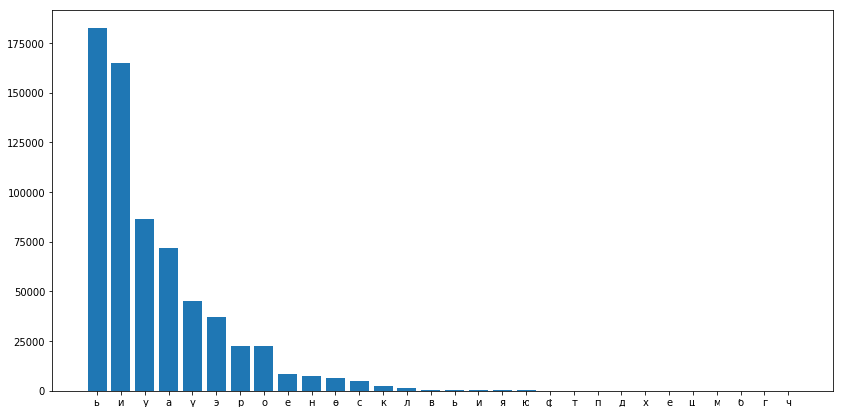

In [82]:
diag('т')

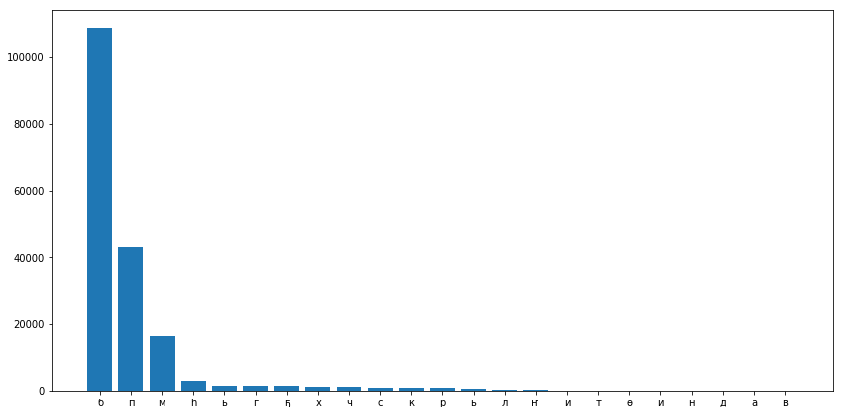

In [83]:
diag('ыт')

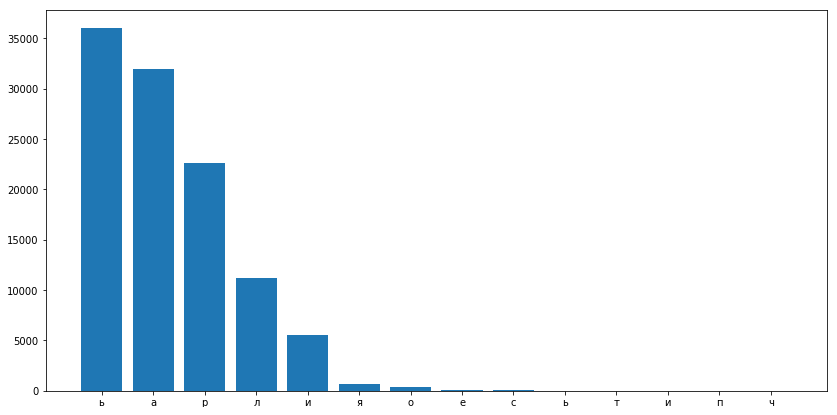

In [84]:
diag('быт')

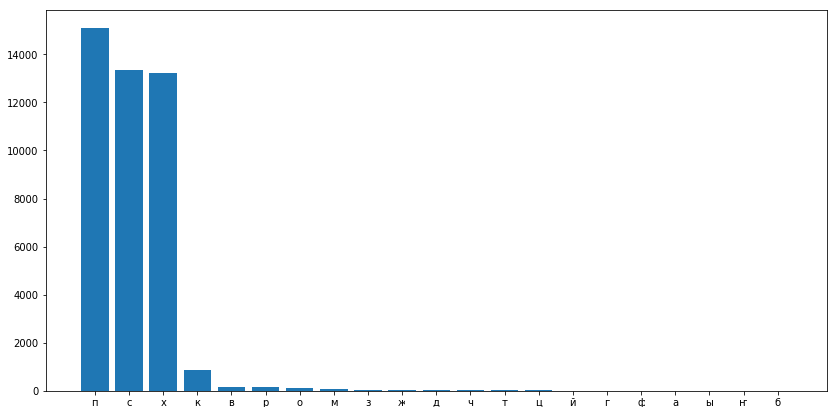

In [85]:
diag('пыт')

In [25]:
extend_right('э',-2,0)#перед ним какие буквы

'эн'

In [91]:
build_trie()

NameError: name 'build_trie' is not defined